# Remoção da Tendência Temporal
Primeiro avaliamos transformações para remover tendência das séries semanais de `volume`, `inv` e `users`.


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

plt.style.use("seaborn-v0_8")


Carregamos dataset.

In [18]:
data_path = "data/data_updated.csv"
df = pd.read_csv(data_path, parse_dates=["week"])
df = df.sort_values("week").set_index("week")

series_names = ["volume", "inv", "users"]
series_dict = {name: df[name].astype(float) for name in series_names}
df[series_names].head()


,volume,inv,users
week,,,
2022-10-31,0.38,1.609882,6.500
2022-11-07,0.47,1.880548,7.061
2022-11-14,0.32,2.297810,5.875
2022-11-21,1.69,5.623875,24.238
2022-11-28,1.23,1.473418,7.648


E olhamos o formato de cada uma das séries consideradas. Está bastante claro, em especial para a série de `volume`, que há forte autocorrelação.

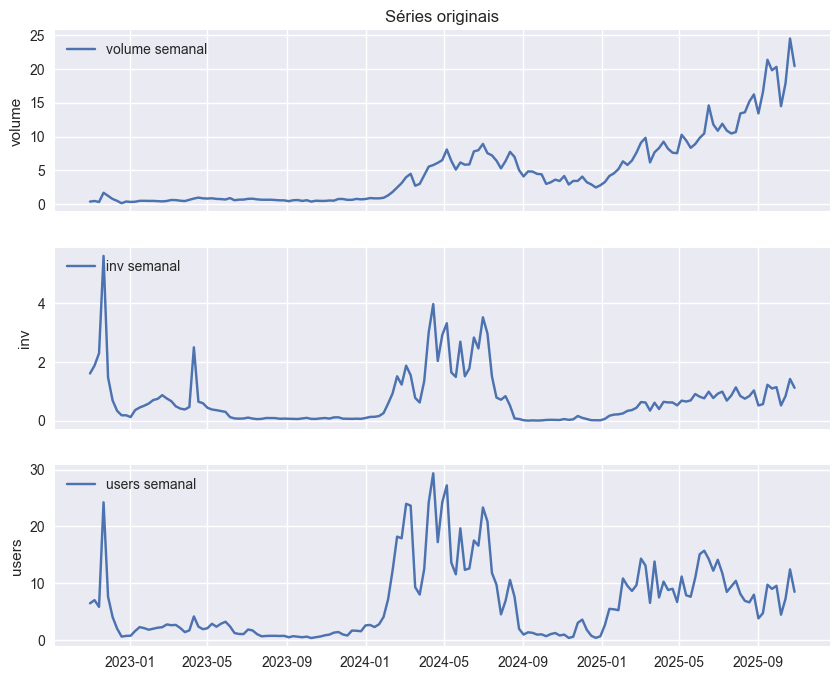

In [19]:
fig, axes = plt.subplots(len(series_names), 1, figsize=(10, 8), sharex=True)
for ax, name in zip(axes, series_names):
    ax.plot(series_dict[name], label=f"{name} semanal")
    ax.set_ylabel(name)
    ax.legend(loc="upper left")
axes[0].set_title("Séries originais")
plt.show()


Criamos, então, uma função que avalie a qualidade de uma transformação no conjunto de dados, na medida em que ela consegue suprimir a autocorrelação da série. Ela aplica o teste *Augmented Dickey-Fuller (ADF)*, que é comumente usado para testar a estacionariedade de uma série.

In [20]:
def evaluate_transformation(series: pd.Series, transform_name: str, series_name: str):
    clean_series = series.dropna()
    result = adfuller(clean_series.values)
    return {
        "series": series_name,
        "transform": transform_name,
        "p_value": result[1],
        "test_stat": result[0],
        "n_obs": result[3],
    }

transforms = []


Nesse caso, consideraremos a diferença simples e a diferença dos logaritmos como possíveis transformações.

In [21]:
transform_funcs = {
    "Diferença de primeira ordem": lambda s: s.diff(),
    "Diferença do log(x)": lambda s: np.log(s).diff()
}

transformed_series = {}
for series_name, series in series_dict.items():
    transformed_series[series_name] = {}
    for transform_name, func in transform_funcs.items():
        transformed = func(series)
        transformed_series[series_name][transform_name] = transformed.dropna()
        transforms.append(
            evaluate_transformation(transformed, transform_name, series_name)
        )


In [22]:
results = pd.DataFrame(transforms).sort_values(["series", "p_value"])
results


,series,transform,p_value,test_stat,n_obs
3,inv,Diferença do log(x),1.946696e-26,-14.178552,155
2,inv,Diferença de primeira ordem,8.077797e-23,-12.284635,154
5,users,Diferença do log(x),4.227659e-18,-10.261388,154
4,users,Diferença de primeira ordem,2.878416e-12,-7.965139,152
1,volume,Diferença do log(x),2.549212e-07,-5.917731,151
0,volume,Diferença de primeira ordem,4.020645e-06,-5.364465,151


Avaliando os p-valores, temos que a diferença do logaritmo parece ser a melhor transformação.

In [23]:
best_per_series = (
    results.sort_values("p_value").groupby("series").first().reset_index()
)
for _, row in best_per_series.iterrows():
    print(
        f"Série {row.series}: {row.transform} -> p-valor {row.p_value:.4f}, estatística {row.test_stat:.3f}"
    )

best_per_series


Série inv: <bound method Series.transform of series                       inv
transform    Diferença do log(x)
p_value                      0.0
test_stat             -14.178552
n_obs                        155
Name: 0, dtype: object> -> p-valor 0.0000, estatística -14.179
Série users: <bound method Series.transform of series                     users
transform    Diferença do log(x)
p_value                      0.0
test_stat             -10.261388
n_obs                        154
Name: 1, dtype: object> -> p-valor 0.0000, estatística -10.261
Série volume: <bound method Series.transform of series                    volume
transform    Diferença do log(x)
p_value                      0.0
test_stat              -5.917731
n_obs                        151
Name: 2, dtype: object> -> p-valor 0.0000, estatística -5.918


,series,transform,p_value,test_stat,n_obs
0,inv,Diferença do log(x),1.946696e-26,-14.178552,155
1,users,Diferença do log(x),4.227659e-18,-10.261388,154
2,volume,Diferença do log(x),2.549212e-07,-5.917731,151


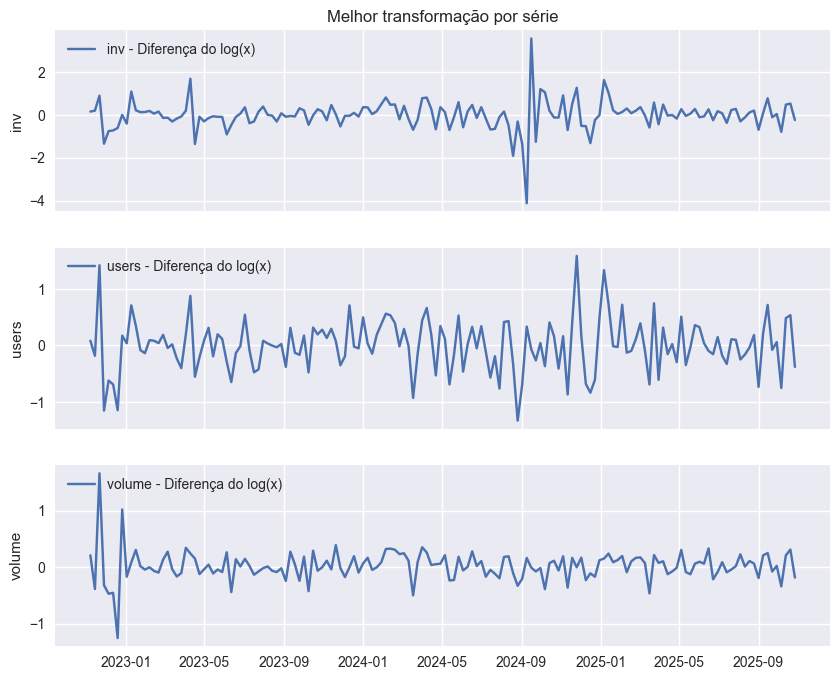

In [24]:
fig, axes = plt.subplots(len(best_per_series), 1, figsize=(10, 8), sharex=True)
axes = np.atleast_1d(axes)
for ax, row in zip(axes, best_per_series.itertuples()):
    best_series = transformed_series[row.series][row.transform]
    ax.plot(best_series, label=f"{row.series} - {row.transform}")
    ax.set_ylabel(row.series)
    ax.legend(loc="upper left")
axes[0].set_title("Melhor transformação por série")
plt.show()
